# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

---
freeze: true
format:
  html:
    embed-resources: true
    # optional: use a local theme to avoid remote fonts
    theme: default
---


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [2]:
!pip install palmerpenguins
import pandas as pd
from palmerpenguins import load_penguins
penguins = load_penguins()

In [3]:
penguins.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


In [20]:
df = pd.get_dummies(penguins, columns=['species','island','sex'], drop_first=True, dtype="int64")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_length_mm     342 non-null    float64
 1   bill_depth_mm      342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   year               344 non-null    int64  
 5   species_Chinstrap  344 non-null    int64  
 6   species_Gentoo     344 non-null    int64  
 7   island_Dream       344 non-null    int64  
 8   island_Torgersen   344 non-null    int64  
 9   sex_male           344 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 27.0 KB


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [18]:
# My best multiple linear regression model from before is all features including dummies

from sklearn.linear_model import LinearRegression

df1 = df.dropna(subset=['bill_depth_mm']).dropna()

y = df1['bill_depth_mm'].values
X = df1.drop(columns='bill_depth_mm')

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)


LinearRegression()

In [58]:
# Two kNN models

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()

X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X_scaled[num_cols])

num_cols = [c for c in ['bill_length_mm','flipper_length_mm','body_mass_g','year'] if c in X.columns]
pre = ColumnTransformer([('num', StandardScaler(), num_cols)],
                        remainder='passthrough')  # keep dummies as-is (0/1)

pipe = Pipeline([('pre', pre), ('knn', KNeighborsRegressor())])

param_grid = {
    'knn__n_neighbors': [1,3,5,7,9,11,15,21,31]}

cv = KFold(n_splits=5, shuffle=True, random_state=0)

gcv = GridSearchCV(pipe, param_grid, cv=cv,
                   scoring='neg_root_mean_squared_error',
                   n_jobs=-1, return_train_score=True, refit=True)
gcv.fit(X, y)

print("Best params:", gcv.best_params_)
print("Best CV RMSE:", -gcv.best_score_)

Best params: {'knn__n_neighbors': 7}
Best CV RMSE: 0.8226697248454476


In [55]:
#one-SE rule: pick the largest k whose CV error is within one SE of the minimum

res   = gcv.cv_results_
means = -res['mean_test_score']                 # CV RMSE (mean)
stds  =  res['std_test_score']                  # SD across folds
ks    =  res['param_knn__n_neighbors'].data.astype(int)

# folds used in CV
K = gcv.cv if isinstance(gcv.cv, int) else gcv.cv.get_n_splits()

# best k and one-SE alternative (choose the largest k within 1 SE of the minimum)
best_idx = int(np.argmin(means))
best_k   = int(ks[best_idx])
one_se   = stds[best_idx] / np.sqrt(K)
alt_k    = int(ks[means <= means[best_idx] + one_se].max())

print("Alt k (one-SE): ", alt_k)

Alt k (one-SE):  31


In [56]:
knn7 = Pipeline([('pre', pre), ('knn', KNeighborsRegressor(n_neighbors=7))])
knn7.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).



Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g', 'year'])])),
                ('knn', KNeighborsRegressor(n_neighbors=7))])

In [49]:
knn31 = Pipeline([('pre', pre), ('knn', KNeighborsRegressor(n_neighbors=31))])
knn31.fit(X, y)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g', 'year']),
                                                 ('cat', 'passthrough',
                                                  ['species_Chinstrap',
                                                   'species_Gentoo',
                                                   'island_Dream',
                                                   'island_Torgersen',
                                                   'sex_male'])])),
                ('knn', KNeighborsRegressor(n_neighbors=31))])

In [47]:
# a decision tree

tree_pipe = Pipeline([
    ("tree", DecisionTreeRegressor(random_state=0))
])

param_grid = {
    "tree__max_depth": [None, 3, 5, 7, 10],
    "tree__min_samples_leaf": [1, 3, 5, 10]
}

gcv_tree = GridSearchCV(
    tree_pipe, param_grid, cv=5,
    scoring="neg_mean_squared_error", n_jobs=-1, refit=True
).fit(X, y)

best_tree = gcv_tree.best_estimator_

In [60]:
gcv_res = gcv.cv_results_
means = -gcv_res['mean_test_score']
stds  =  gcv_res['std_test_score']
ks    =  gcv_res['param_knn__n_neighbors'].data.astype(int)


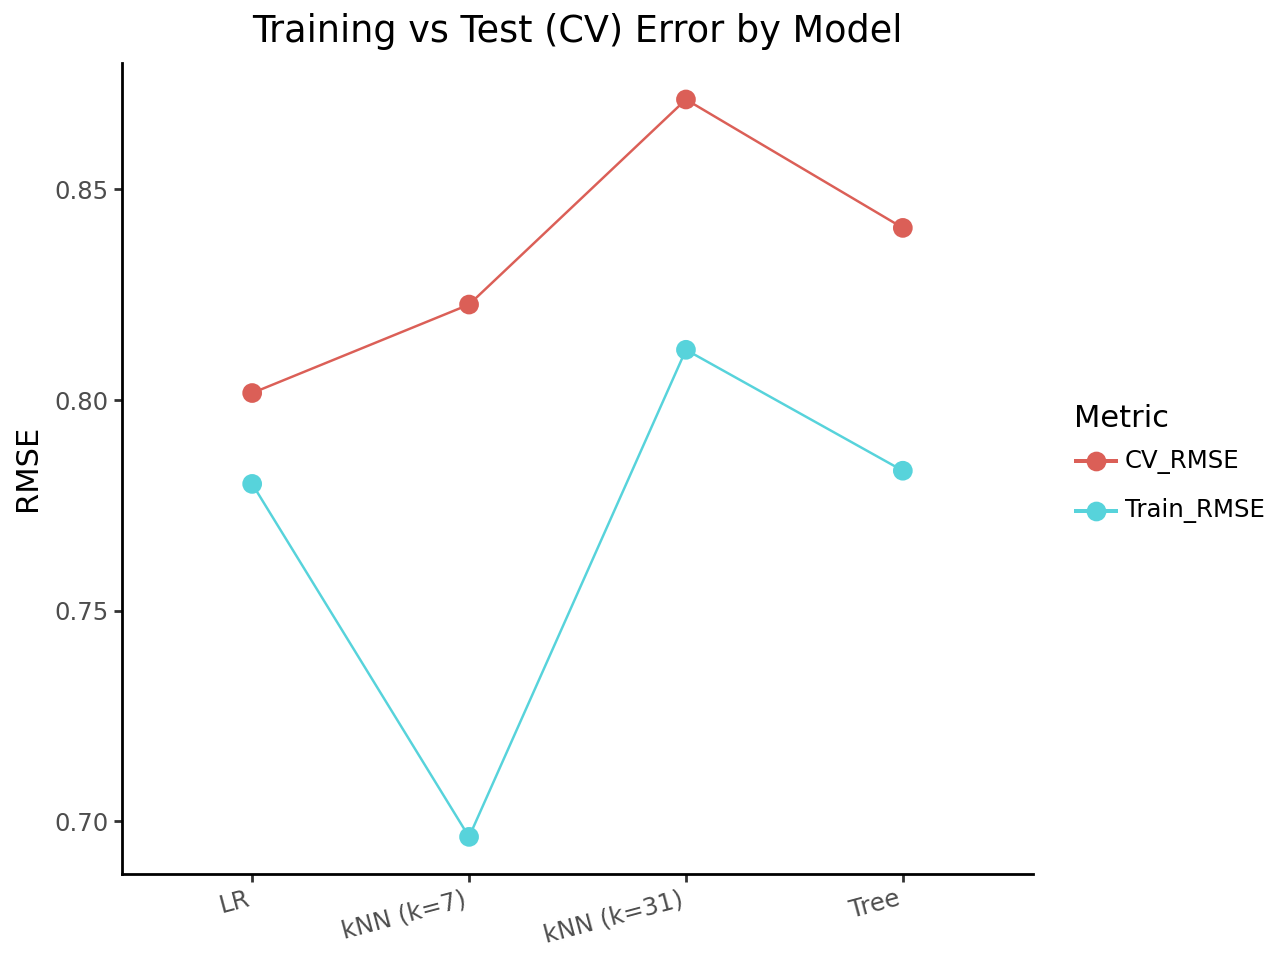

In [63]:
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_classic, theme, element_text

res_df = pd.DataFrame(rows, columns=["Model","Train_RMSE","CV_RMSE"])  # don't reuse 'res' name

res_long = (res_df
            .melt(id_vars="Model", var_name="Metric", value_name="RMSE"))

order = ["LR", "kNN (k=7)", "kNN (k=31)", "Tree"]
res_long["Model"] = pd.Categorical(res_long["Model"], categories=order, ordered=True)

p = (
    ggplot(res_long, aes(x="Model", y="RMSE", color="Metric", group="Metric"))
    + geom_line()
    + geom_point(size=3)
    + labs(title="Training vs Test (CV) Error by Model", x="", y="RMSE")
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=15, ha="right"))
)
p



Analysis:

Linear Regression is the best one since it has the lowest CV (test) RMSE on the plot (~0.80), lower than kNN-7 (~0.82), kNN-31 (~0.87), and the Tree (~0.84).